In [ ]:
pip install imbalanced-learn

In [3]:
pip install nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
data = pd.read_csv("data/data.csv")
print("Number of entries in CSV:", len(data))

Number of entries in CSV: 9525


In [2]:
df = pd.read_csv("data/processed_data.csv")
print(df['rating_star'].value_counts())

rating_star
2    4438
0    3123
1    1964
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from imblearn.over_sampling import SMOTE

df = pd.read_csv("data/processed_data.csv")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["comment"], df["rating_star"], test_size=0.2, random_state=42, stratify=df["rating_star"]
)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), stop_words="english", min_df=2, max_df=0.9)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

smote = SMOTE(sampling_strategy="auto", k_neighbors=3, random_state=42)
X_train_resampled, train_labels_resampled = smote.fit_resample(X_train, train_labels)

svm_param_grid = {
    "C": [0.1, 1, 10, 20],
    "kernel": ["linear", "rbf"],  
    "gamma": ["scale", "auto", 0.01, 0.1], 
    "class_weight": ["balanced"],  
}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
svm_grid.fit(X_train_resampled, train_labels_resampled)

joblib.dump(svm_grid.best_estimator_, "best_svm.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Best SVM Parameters:", svm_grid.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best SVM Parameters: {'C': 20, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

vectorizer = joblib.load("tfidf_vectorizer.pkl")

rf_param_grid = {
    "n_estimators": [100, 200, 300], 
    "max_depth": [5, 10, 20, 40],  
    "min_samples_split": [ 6, 8,10],  
    "min_samples_leaf": [2, 4, 6], 
    "max_features": ["sqrt", "log2"],  
    "class_weight": ["balanced"],  
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
rf_grid.fit(X_train_resampled, train_labels_resampled)

joblib.dump(rf_grid.best_estimator_, "best_rf.pkl")
print("Best Random Forest Parameters:", rf_grid.best_params_)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Random Forest Parameters: {'class_weight': 'balanced', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 300}


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

vectorizer = joblib.load("data/tfidf_vectorizer.pkl")
best_svm = joblib.load("data/best_svm.pkl")
best_rf = joblib.load("data/best_rf.pkl")

X_val = vectorizer.transform(val_texts)

svm_val_preds = best_svm.predict_proba(X_val)
rf_val_preds = best_rf.predict_proba(X_val)

logistic_features_val = np.hstack((svm_val_preds, rf_val_preds))

scaler = MinMaxScaler()
logistic_features_val_scaled = scaler.fit_transform(logistic_features_val)

logistic_param_grid = [
    {
        "C": [0.005, 0.05, 0.5, 1, 5, 10], 
        "solver": ["saga"], 
        "max_iter": [50,100, 200, 300, 500],  
        "penalty": ["l1", "l2",], 
        "class_weight": ["balanced"], 
    },
]

logistic_grid_search = GridSearchCV(
    LogisticRegression(class_weight="balanced", random_state=42),
    logistic_param_grid,
    cv=10,  
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

logistic_grid_search.fit(logistic_features_val_scaled, val_labels)

best_logistic_model = logistic_grid_search.best_estimator_

joblib.dump(best_logistic_model, "data/best_logistic_model.pkl")

logistic_val_preds = best_logistic_model.predict(logistic_features_val_scaled)

print("\nBest Logistic Regression Parameters:", logistic_grid_search.best_params_)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits

Best Logistic Regression Parameters: {'C': 0.005, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'saga'}


c:\Users\XLewi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


In [194]:
from sklearn.metrics import f1_score, precision_score, recall_score, log_loss, confusion_matrix

svm_train_preds = best_svm.predict_proba(X_train_resampled)
rf_train_preds = best_rf.predict_proba(X_train_resampled)

logistic_features_train = np.hstack((svm_train_preds, rf_train_preds))
logistic_features_val = np.hstack((svm_val_preds, rf_val_preds))

train_preds_proba = best_logistic_model.predict_proba(logistic_features_train)
val_preds_proba = best_logistic_model.predict_proba(logistic_features_val)

train_preds = np.argmax(train_preds_proba, axis=1)
val_preds = np.argmax(val_preds_proba, axis=1)

train_loss = log_loss(train_labels_resampled, train_preds_proba)
val_loss = log_loss(val_labels, val_preds_proba)
accuracy = np.mean(val_preds == val_labels)
f1 = f1_score(val_labels, val_preds, average="weighted")
precision = precision_score(val_labels, val_preds, average="weighted")
recall = recall_score(val_labels, val_preds, average="weighted")
conf_matrix = confusion_matrix(val_labels, val_preds)

print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Training Loss: 0.6151
Validation Loss: 0.7959
Accuracy: 0.7617
F1 Score: 0.7541
Precision: 0.7530
Recall: 0.7617

Confusion Matrix:
[[497  52  75]
 [ 94 183 116]
 [ 61  56 771]]


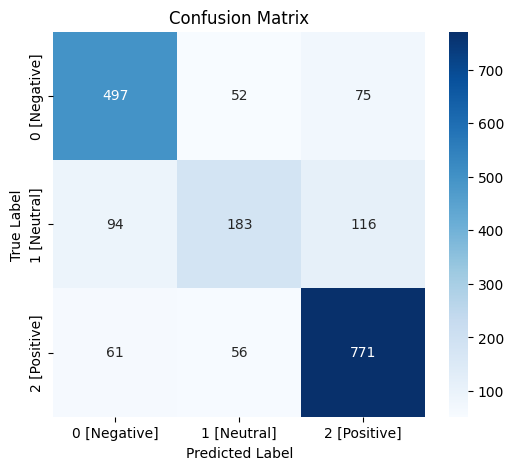

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ["0 [Negative]", "1 [Neutral]", "2 [Positive]"]

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import joblib
import numpy as np

vectorizer = joblib.load("meta_pkl/tfidf_vectorizer.pkl")
svm_model = joblib.load("meta_pkl/best_svm.pkl")
rf_model = joblib.load("meta_pkl/best_rf.pkl")
meta_model = joblib.load("meta_pkl/best_logistic_model.pkl")

def predict_rating(input_text):
    input_vector = vectorizer.transform([input_text])

    svm_pred = svm_model.predict_proba(input_vector)
    rf_pred = rf_model.predict_proba(input_vector)

    meta_features = np.hstack((svm_pred, rf_pred))

    final_pred = meta_model.predict(meta_features)
    
    rating_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return rating_map[final_pred[0]]

user_text = input("Enter a review: ")
predicted_rating = predict_rating(user_text)

print(f"Predicted Rating: {predicted_rating}")

Predicted Rating: Neutral
